In [1]:
import sys
sys.path.append('/SEE-VCN/see')

from see_vcn_dataset import SEE_VCN_Demo
from surface_completion.models.VCN import VCN
import numpy as np
from easydict import EasyDict
import open3d as o3d
from datasets.shared_utils import draw_lidar_on_image, get_pts_in_mask, convert_to_o3dpcd

# Edit dataset configs here
gpu_id = 0
see_vcn_demo = SEE_VCN_Demo(root_dir='/SEE-VCN/demo/demo_data',
                    camera='front',
                    config_file = '/SEE-VCN/see/detector2d/mmdetection/configs/htc/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco.py',
                    checkpoint_file = '/SEE-VCN/model_zoo/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_20200312-946fd751.pth',
                    gpu_id=gpu_id)

vcn = VCN(cfg=EasyDict({ 'MODEL': "VCN_VC", 
                         'NORM_WITH_GT': False,
                         'SEL_K_NEAREST': 20,
                         'CLUSTER_EPS': 0.2,
                         'BATCH_SIZE_LIMIT': 32,
                         'CKPT_PATH': "/SEE-VCN/model_zoo/VCN_VC.pth"}), 
                          gpu_id=gpu_id)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-09-14 02:11:59,827 - driver - Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO - 2022-09-14 02:11:59,840 - driver - Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.7/dist-packages/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /SEE-VCN/model_zoo/htc_x101_64x4d_fpn_dconv_c3-c5_mstrain_400_1400_16x1_20e_coco_20200312-946fd751.pth
VCN_VC initialised, batch_size_limit: 32


## SEE-VCN

In [9]:
# Load
idx = 1
eps_scaling = 3
vres = 0.4
image_thresh = 0.3

image = see_vcn_demo.get_image(idx)
points = see_vcn_demo.get_pointcloud(idx)
calib = see_vcn_demo.get_calibration(idx)
imgfov = see_vcn_demo.map_pointcloud_to_image(calib, image, points)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


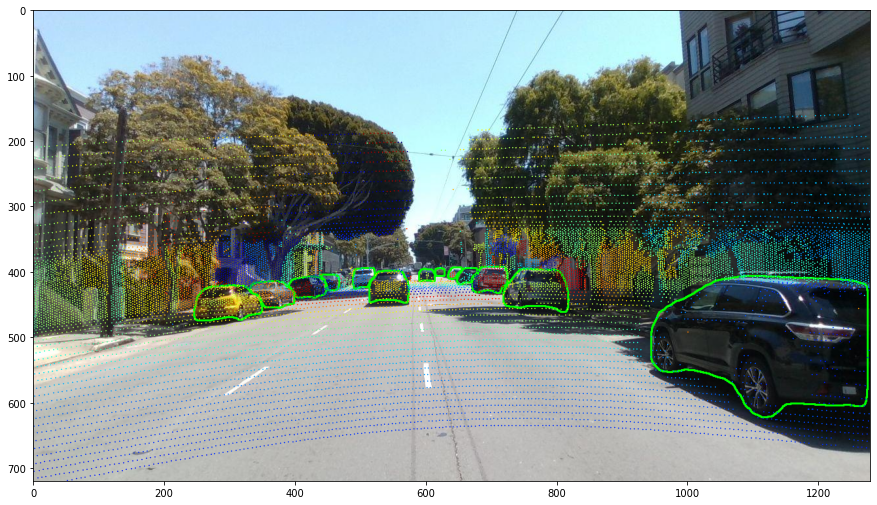

In [10]:
instances = see_vcn_demo.get_camera_instances(image, score_thresh=0.5, class_ids=[2,7])
_ = draw_lidar_on_image(imgfov['pts_img'], 
                                 image, 
                                 instances, 
                                 point_size=2,
                                 map_range=40.0,
                                 instance_mask=True)

In [11]:
instance_pts = get_pts_in_mask(see_vcn_demo.coco, 
                                instances, 
                                imgfov,
                                shrink_percentage=3,
                                use_bbox=False)
iso_pts = see_vcn_demo.isolate(instance_pts['lidar_xyz'], eps_scaling=eps_scaling, vres=vres)

# Complete surfaces
sc_model_ret = vcn.inference(iso_pts,
                            batch_size_limit=vcn.batch_size_limit,                                         
                            k=vcn.surface_sel_k)
sc_model_ret['all_instances'] = np.unique(np.vstack(sc_model_ret['clustered']), axis=0)

# Augment pointcloud
sc_instances = sc_model_ret['all_instances']
final_pcd = see_vcn_demo.replace_with_completed_pts(points, sc_instances)

In [12]:
# Visualize augmented point cloud 
original_pcd = convert_to_o3dpcd(points)
original_pcd.paint_uniform_color([0.8,0.8,0.8])

pcd2 = convert_to_o3dpcd(sc_instances)

# Remove the original points of the cars
dist = original_pcd.compute_point_cloud_distance(pcd2)
cropped_inds = np.where(np.asarray(dist) < 0.1)[0]
pcd_without_object = original_pcd.select_by_index(cropped_inds, invert=True)

# o3d.visualization.draw_geometries([pcd2, pcd_without_object])

# 3D detection

In [13]:
sys.path.append('/SEE-VCN/detector3d')
from pcdet.utils import common_utils
from pcdet.models import build_network, load_data_to_gpu
from pathlib import Path
import torch
from openpcdet_dataset import OPD_Demo, opd_to_o3dbox, cfg_from_yaml_file
from pcdet.config import cfg

cfg_file = '/SEE-VCN/detector3d/tools/cfgs/source-waymo/second_iou.yaml'
ckpt = '/SEE-VCN/model_zoo/waymo_secondiou_see_vcn.pth'
shift_coor = [0.0,0.0,1.8]

if 'model' not in locals():     
    cfg_from_yaml_file(cfg_file, cfg)

    logger = common_utils.create_logger()
    demo_dataset = OPD_Demo(
            dataset_cfg=cfg.DATA_CONFIG_TAR, class_names=cfg.CLASS_NAMES, training=False,
            root_path=see_vcn_demo.root_dir / 'pcd', ext='.pcd', logger=logger)

    model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=demo_dataset)
    model.load_params_from_file(filename=ckpt, logger=logger, to_cpu=True)
    model.cuda()
    model.eval()
    print('Model loaded')
else:
    print('Already loaded')

Already loaded


In [14]:
input_dict = {
    'points': final_pcd,
    'frame_id': 0,
}
final_pcd[:, 0:3] += np.array(shift_coor, dtype=np.float32)
new_data_dict = demo_dataset.prepare_data(data_dict=input_dict)
new_data_dict = demo_dataset.collate_batch([new_data_dict])

with torch.no_grad():
    load_data_to_gpu(new_data_dict)
    pred_dicts, _ = model.forward(new_data_dict)

In [15]:
# Visualize predicted boxes

o3d_boxes = opd_to_o3dbox(pred_dicts, shift_coor=shift_coor, score_thresh=0.4)
o3d.visualization.draw_geometries([convert_to_o3dpcd(points)] + o3d_boxes)